In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use("ggplot")
pd.options.display.max_columns = 999

In [3]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

TRAIN_DATA_PATH = "train_data.csv"
TEST_DATA_PATH = "test_data.csv"

train = pd.read_csv(TRAIN_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
train = train.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

test = pd.read_csv(TEST_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
test = test.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [16]:
print(f"-------------- train dataset --------------")
int(f"-------------- train dataset --------------")
print(f"user 명수            : {train.userID.nunique()} 명")
print(f"assesmentItemID 종류 : {train.assessmentItemID.nunique()}")
print(f"test_id 시험지 종류    : {train.testId.nunique()}")
print(f"정답률                : {train.answerCode.sum() / train.shape[0] * 100:.1f} %")
print(f"KnowledgeTag 종류    : {train.KnowledgeTag.nunique()}")
print(f"-------------- test  dataset --------------")
print(f"user 명수            : {test.userID.nunique()} 명")
print(f"assesmentItemID 종류 : {test.assessmentItemID.nunique()}")
print(f"test_id 시험지 종류    : {test.testId.nunique()}")
print(f"정답률                : {test.answerCode.sum() / test.shape[0] * 100:.1f} %")
print(f"KnowledgeTag 종류    : {test.KnowledgeTag.nunique()}")

-------------- train dataset --------------
user 명수            : 6698 명
assesmentItemID 종류 : 9454
test_id 시험지 종류    : 1537
정답률                : 65.4 %
KnowledgeTag 종류    : 912
-------------- test  dataset --------------
user 명수            : 744 명
assesmentItemID 종류 : 9454
test_id 시험지 종류    : 1537
정답률                : 65.2 %
KnowledgeTag 종류    : 912


In [451]:
train['month'] = train['Timestamp'].dt.month
train['day'] = train['Timestamp'].dt.day
train['hour'] = train['Timestamp'].dt.hour
train['minute'] = train['Timestamp'].dt.minute
train['second'] = train['Timestamp'].dt.second

In [452]:
train['test_group'] = train['testId'].apply(lambda x: x[2])

## statistical

### 1) User 에 따른 통계량

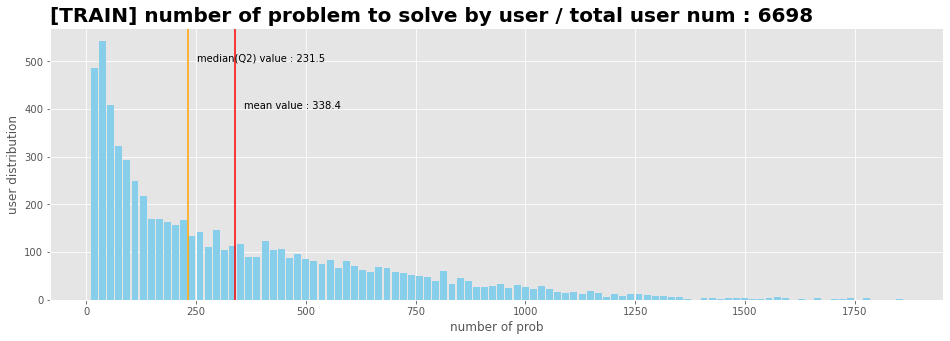

In [21]:
plt.figure(figsize=(16,5))
plt.hist(train.groupby("userID")['answerCode'].count(), bins = 100, rwidth=0.85, color='skyblue')
plt.title(f"[TRAIN] number of problem to solve by user / total user num : {len(train.groupby('userID')['answerCode'].count())}", loc='left', weight='bold', size=20)
plt.xlabel('number of prob')
plt.ylabel('user distribution')
_mean = train.groupby("userID")['answerCode'].count().mean()
_median = train.groupby("userID")['answerCode'].count().median()
plt.axvline(x = _mean, color = 'r')
plt.axvline(x = _median, color = 'orange')
plt.text(x = _mean+20, y = 400,s = f"mean value : {_mean:.1f}"  )
plt.text(x = _median+20, y = 500,s = f"median(Q2) value : {_median:.1f}"  );

* user 별로 푼 문제의 수를 나타낸다.
1. 문제를 적게 푼 사람이 400~500 명씩 꽤 많은 분포가 있는 것을 알 수 있다.  
    : `문제 수가 적을 수록 과적합될 여지`가 많기 때문에, `문제를 적게 푼 user 에 대해서 모델의 결과값을 비교 분석`할 필요가 있겠다.

In [454]:
for x in [50, 100, 150, 200]:
    print(f"{x} 문제 이하로 푼 user 의 전체 대비 비율 : \
    {(train.groupby('userID')['answerCode'].count() < x).sum() / len(train.groupby('userID')['answerCode'].count())*100:.2f}%")

50 문제 이하로 푼 user 의 전체 대비 비율 :     16.45%
100 문제 이하로 푼 user 의 전체 대비 비율 :     30.20%
150 문제 이하로 푼 user 의 전체 대비 비율 :     39.31%
200 문제 이하로 푼 user 의 전체 대비 비율 :     45.76%


위처럼 문제를 적게 풀면 과적합될 확률이 올라가는데, 결과 비교를 추후에 대조해볼 필요가 있겠다.

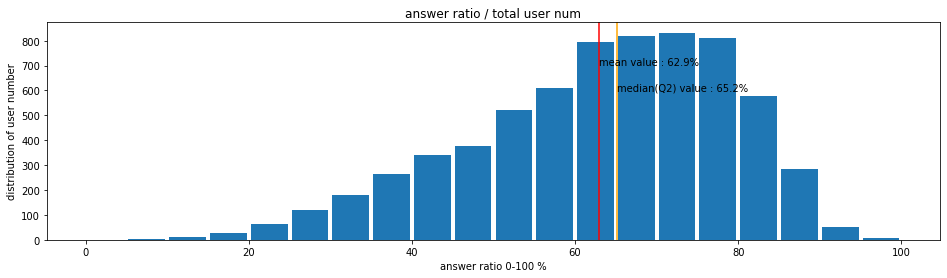

In [455]:
plt.figure(figsize=(16,4))
answer_ratio_by_user = train.groupby('userID')['answerCode'].sum()/train.groupby('userID')['answerCode'].count()*100
plt.hist(answer_ratio_by_user, bins = 20, rwidth=0.9)
plt.title(f"answer ratio / total user num")
plt.xlabel('answer ratio 0-100 %')
plt.ylabel('distribution of user number')
_mean = answer_ratio_by_user.mean()
_median = answer_ratio_by_user.median()
plt.axvline(x = _mean, color = 'r')
plt.axvline(x = _median, color = 'orange')
plt.text(x = _mean, y = 700,s = f"mean value : {_mean:.1f}%")
plt.text(x = _median, y = 600,s = f"median(Q2) value : {_median:.1f}%");

* 학생별 정답률의 분포는 bins 20 으로 위와 같다. 평균 60%대 정도가 나오는 것을 알 수 있다.

### 2) 시험지에 따른 통계량

In [456]:
print(f"testId 의 종류 : {train.testId.nunique()}")

testId 의 종류 : 1537


2번째 자리에 의해서 정답률이 달라지는 분포가 생기므로 관련하여 groupby 시켜보자.

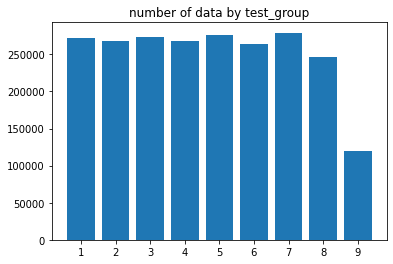

In [457]:
t_group = train['test_group'].value_counts()
t_group = t_group.sort_index()
plt.bar(t_group.index, t_group.values)
plt.title('number of data by test_group');

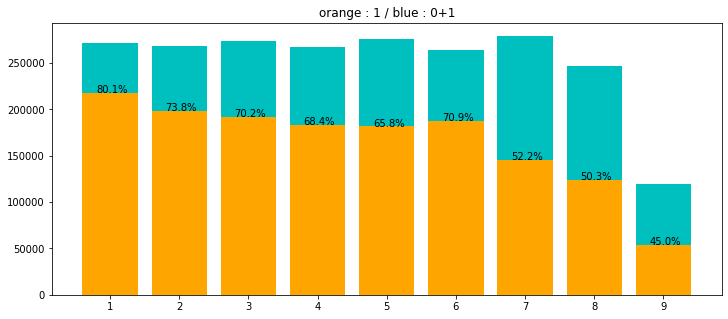

In [458]:
t_sum = train.groupby('test_group')['answerCode'].sum()
t_count = train.groupby('test_group')['answerCode'].count()
t_answer = train.groupby('test_group')['answerCode'].sum()/train.groupby('test_group')['answerCode'].count()*100

plt.figure(figsize=(12,5))
plt.bar(t_count.index, t_count.values, color='c')
plt.bar(t_sum.index, t_sum.values, color='orange')
plt.title('orange : 1 / blue : 0+1')

for i in range(9):
    plt.text(x = int(t_answer.index[i])-1.2,
             y = t_sum.values[i],
             s = f"{t_answer[i]:.1f}%")
    
plt.show();

* test_group 에 따른 정답률이 다른 것을 알 수 있다.

In [459]:
print(f"user 별로 test_group 의 종류에 몇 가지나 노출 되는가? : {train.groupby('userID')['test_group'].nunique().unique()}")

user 별로 test_group 의 종류에 몇 가지나 노출 되는가? : [3 2 1]


1. user 별로 test_group 에 최소 1가지에서 최대 3가지까지 노출 된다.
2. test_group 의 숫자가 올라가면서 정답률이 떨어지는 경향성으로 보아 `문제(테스트 시험지)의 난이도`에 관한 지표일 수도 있겠다.

3. 토론 글을 참고하여 초등학교 1-6학년, 중학교 1-3학년 문제라고 볼 수 도 있다.
4. 각 user 가 최대 3가지 test_group 에 노출되는 것을 보면 선수학습을 생각할 수 있고, 가장 낮은 숫자가 user의 나이(학년)라고 추정할 수도 있겠다.
5. 선수학습을 한 것이라면 그 경우에는 정답률이 더 낮을 수 있겠다. 즉, 본인 나이에 맞는 문제를 풀지 않을 경우 정답률이 더 낮을 수 있겠다.
6. 각 user 별 노출되는 test_group 의 nunique 를 추가해줄 경우, 각 학생의 학습 수준에 대한 간접정보를 추가할 수 있겠다.
7. 9번 그룹이더라도 그 학년이 풀었을 때의 정답률과 선수학습을 해서 풀었을 때의 정답률을 비교해보자.
8. 주어진 숫자가 연속된 1-9 학년을 나타내는 것이 아닐 수 있다. 실제 순서와 매칭되는 순서를 찾아보자.
9. 만약 주어진 데이터가 한 user 의 모든 선수학습 데이터를 포함하지 않을 수도 있다. (그럼 4년 이상의 선수학습?)

In [460]:
# 선수학습, 나이추정, 수준추정, 선수학습 하는 사람에 따른 각 그룹별 정답률 추정

In [461]:
_unique = train.groupby('userID')['test_group'].unique().to_frame("unique")
_unique['len'] = _unique['unique'].apply(lambda x: len(x))
_unique

,unique,len
userID,,
0,"[6, 8, 2]",3
1,"[4, 9]",2
2,"[3, 5]",2
5,"[8, 1, 6]",3
6,"[3, 4]",2
...,...,...
7436,"[5, 3]",2
7437,"[4, 6]",2
7438,"[8, 4, 3]",3


In [462]:
for x in [1,2,3]:
    print(f"난이도 {x} 개를 푼 user 의 수 : {(_unique['len']==x).sum()}")

난이도 1 개를 푼 user 의 수 : 102
난이도 2 개를 푼 user 의 수 : 2138
난이도 3 개를 푼 user 의 수 : 4458


In [463]:
_uni1 = _unique[_unique['len'] == 1]
_uni1['f'] = _uni1['unique'].apply(lambda x: x[0])
display(_uni1.head(), _uni1.shape)

,unique,len,f
userID,,,
165,[9],1,9
218,[5],1,5
275,[3],1,3
319,[5],1,5
344,[3],1,3


(102, 3)

In [464]:
_uni2 = _unique[_unique['len'] == 2]
_uni2['unique'] = _uni2['unique'].apply(lambda x: sorted(x))
_uni2['f'] = _uni2['unique'].apply(lambda x: x[0]).astype('str')
_uni2['s'] = _uni2['unique'].apply(lambda x: x[1]).astype('str')
_uni2['all'] = _uni2['f'] + _uni2['s']
display(_uni2.head(), _uni2.shape)

,unique,len,f,s,all
userID,,,,,
1,"[4, 9]",2,4,9,49
2,"[3, 5]",2,3,5,35
6,"[3, 4]",2,3,4,34
9,"[4, 7]",2,4,7,47
10,"[4, 6]",2,4,6,46


(2138, 5)

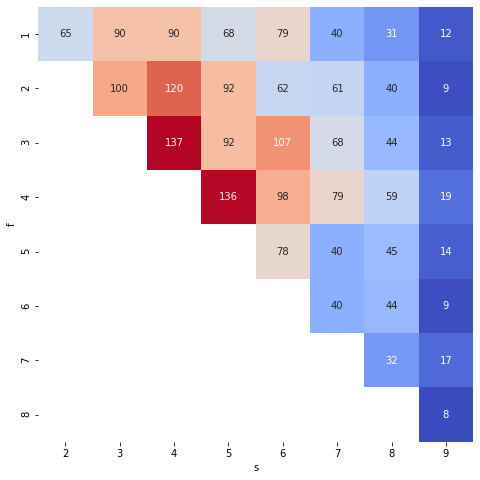

In [465]:
uni2 = _uni2.groupby(['f','s'])['all'].agg(len).unstack()
plt.figure(figsize=(8,8))
sns.heatmap(uni2, annot=True, fmt='.3g', cbar=False, square=True, cmap='coolwarm');

* 1번 난이도를 푼 사람이 2-9 난이도를 푼 갯수를 표현하고 있습니다.
* 2번 난이도를 풀고 1번을 푼 것과 같은 순서는 고려하지 않고 있습니다.
* 이 데이터는 한 유저가 한번에 어떤 난이도를 같이 풀었는지 보여줍니다.
* 학년이라고 하기에는 유저별로 모든 난이도가 고려되고 있습니다.(어떤 유저는 [2,3], [2,9] 식이므로 난이도 == 학년 이라고 보기보다는 다른 상황일 것으로 보입니다.)


In [466]:
_uni3 = _unique[_unique['len'] == 3]
_uni3['unique'] = _uni3['unique'].apply(lambda x: sorted(x))
_uni3['f'] = _uni3['unique'].apply(lambda x: x[0]).astype('str')
_uni3['s'] = _uni3['unique'].apply(lambda x: x[1]).astype('str')
_uni3['t'] = _uni3['unique'].apply(lambda x: x[2]).astype('str')
_uni3['all'] = _uni3['f'] + _uni3['s'] + _uni3['t']
display(_uni3.head(), _uni3.shape)

,unique,len,f,s,t,all
userID,,,,,,
0,"[2, 6, 8]",3,2,6,8,268
5,"[1, 6, 8]",3,1,6,8,168
7,"[2, 5, 9]",3,2,5,9,259
8,"[1, 6, 7]",3,1,6,7,167
11,"[3, 4, 7]",3,3,4,7,347


(4458, 6)

In [467]:
uni_all = pd.concat([_uni1, _uni2])
uni_all = pd.concat([uni_all, _uni3])
uni_all = uni_all.reset_index()
uni_all

,userID,unique,len,f,s,all,t
0,165,[9],1,9,NaN,NaN,NaN
1,218,[5],1,5,NaN,NaN,NaN
2,275,[3],1,3,NaN,NaN,NaN
3,319,[5],1,5,NaN,NaN,NaN
4,344,[3],1,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6693,7427,"[3, 4, 6]",3,3,4,346,6
6694,7428,"[3, 4, 8]",3,3,4,348,8
6695,7429,"[3, 4, 5]",3,3,4,345,5
6696,7435,"[3, 5, 6]",3,3,5,356,6


In [468]:
train = pd.merge(train, uni_all[['userID','len','f','s','t']], on = 'userID', how='left')
display(train.head(), train.shape)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,month,day,hour,minute,second,test_group,len,f,s,t
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3,24,0,17,11,6,3,2,6,8
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3,24,0,17,14,6,3,2,6,8
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,24,0,17,22,6,3,2,6,8
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,24,0,17,29,6,3,2,6,8
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,3,24,0,17,36,6,3,2,6,8


(2266586, 16)

In [509]:
%%time
ratio_by_diff = {k:[] for k in range(1,10)}
for j in range(1,10):
    for i in [1,2,3]:
        try:
            ratio = train[(train['len'] == i) & (train['testId'].apply(lambda x: x[2])==f'{j}')]['answerCode']
            ratio = ratio.sum()/ratio.count() * 100
        except:
            ratio = 0
        ratio_by_diff[j].append(ratio)
print('done')

done
CPU times: user 12.3 s, sys: 488 ms, total: 12.8 s
Wall time: 12.8 s


In [522]:
ratio_by_diff

{1: [79.04155895804334, 80.95826012631179, 79.71523436004311],
 2: [71.23940677966102, 73.70365251479475, 73.83462549064133],
 3: [67.79810447432224, 69.27162019869066, 70.74175295430925],
 4: [66.16017727128838, 68.8715953307393, 68.20082230279479],
 5: [68.67058341303456, 67.04268787534491, 65.1278814489572],
 6: [70.71253071253071, 71.98642544312214, 70.39622781529539],
 7: [39.235500878734626, 52.08991450072571, 52.37995064110129],
 8: [43.563902885936784, 51.28019148473199, 50.02224983384864],
 9: [44.54713493530499, 49.1437323061215, 44.075819587415765]}

* 7,8,9 번에 대해서 정답률 차이가 많이 난다. 데이터 갯수(user 수) 가 적을 가능성이 있다.

In [528]:
for i in [7,8,9]:
    for j in [1,2,3]:
        print(f"{i}번 {j}문제 user 수 : {train[(train['len'] == j) & (train['testId'].apply(lambda x: x[2])==f'{i}')]['userID'].nunique()}")

7번 1문제 user 수 : 4
7번 2문제 user 수 : 377
7번 3문제 user 수 : 1305
8번 1문제 user 수 : 7
8번 2문제 user 수 : 303
8번 3문제 user 수 : 1207
9번 1문제 user 수 : 1
9번 2문제 user 수 : 101
9번 3문제 user 수 : 569


* user 수가 적어 과적합된 것으로 보인다.
* user 별로 난이도를 다양하게 푼다고 해서 정답률이 크게 차이나지는 않는 것으로 보인다.
* 그렇다면 각 난이도가 각 학년을 반영하지 않을 수도 있고, 꼭 많은 난이도를 푼다고 해서 선수학습을 한다고 가정해서도 안되겠다.

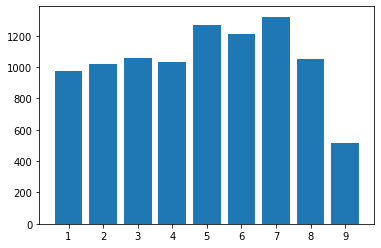

In [241]:
test_assess = train.groupby('test_group')['assessmentItemID'].nunique() # assessmentID : 사용자가 푼 문항의 일련 번호
plt.bar(test_assess.index, test_assess.values);

* test_group 에 따른 문항 가짓수(종류)는 위와 같다.

In [246]:
# user 별 정답률을 봤으니, test 별 정답률의 전반적인 분포도 확인해보자.
def percentile(s):
    return np.sum(s) / len(s)

test_groupby = train.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


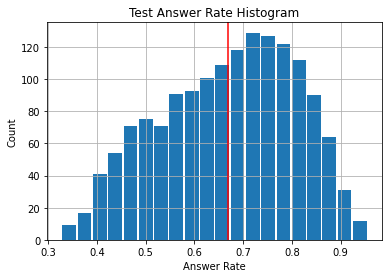

In [254]:
fig, ax = plt.subplots()
plt.hist(test_groupby['answerCode'], bins = 20, rwidth=0.9)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
ax.grid(b=True);

----
## 3) EDA

In [263]:
# by tag
train['KnowledgeTag'].min(), train['KnowledgeTag'].max(), train['KnowledgeTag'].nunique()

(23, 11271, 912)

In [264]:
# tag 노출에 따른 정답률 분포
tag_answer = train.groupby('KnowledgeTag')['answerCode']
tag_sum = tag_answer.sum()
tag_count = tag_answer.count()

In [291]:
tag = tag_sum.to_frame()
tag = pd.concat([tag, tag_count], 1)
tag.columns = ['tag_correct','tag_counts']
tag['answer_ratio'] = tag['tag_correct']/tag['tag_counts']*100
tag['tag_incorrect'] = tag['tag_counts'] - tag['tag_correct'] 
display(tag.head(), tag.shape)

,tag_correct,tag_counts,answer_ratio,tag_incorrect
KnowledgeTag,,,,
23,1052.0,1800,58.444444,748.0
24,220.0,358,61.452514,138.0
25,79.0,92,85.869565,13.0
26,1494.0,2432,61.430921,938.0
30,289.0,539,53.617811,250.0


(912, 4)

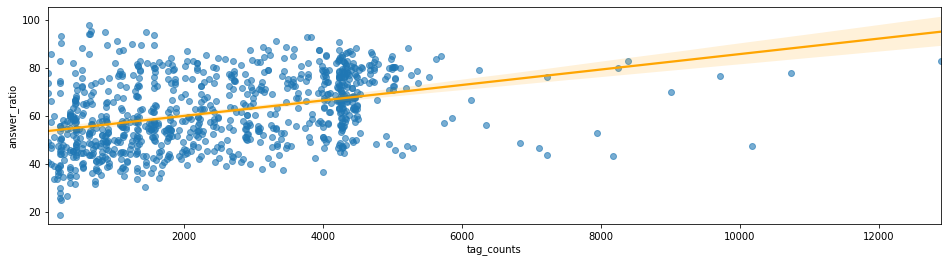

In [360]:
plt.figure(figsize=(16,4))
sns.regplot(data=tag, x='tag_counts', y='answer_ratio',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6});
plt.show();

In [300]:
# 같은 문항 수 별 체크

In [314]:
prob_count_by_user = train.groupby('userID')['answerCode'].count().to_frame('prob_count').reset_index()
display(prob_count_by_user.head(), prob_count_by_user.shape)

,userID,prob_count
0,0,745
1,1,933
2,2,276
3,5,833
4,6,921


(6698, 2)

In [315]:
train = pd.merge(train, prob_count_by_user, how = 'left', on = 'userID')
display(train.head(), train.shape)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,month,day,hour,minute,second,test_group,prob_count
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3,24,0,17,11,6,745
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3,24,0,17,14,6,745
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,24,0,17,22,6,745
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,24,0,17,29,6,745
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,3,24,0,17,36,6,745


(2266586, 13)

In [338]:
prob_count = train.groupby('prob_count')['answerCode'].agg(percentile).to_frame('ratio').reset_index()
prob_count.head()

,prob_count,ratio
0,9,0.555556
1,13,0.666667
2,14,0.629870
3,15,0.612963
4,16,0.547697


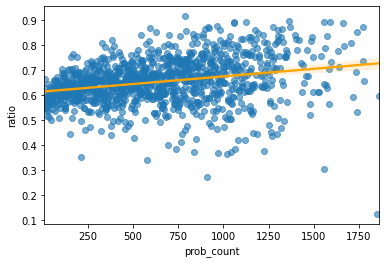

In [339]:
sns.regplot(data=prob_count, x='prob_count', y='ratio',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6});

* Daily mission 1
    : 문제 푼 수에 따른 정답률 : 많이 풀 수록 올라가는 경향은 보인다.

In [356]:
prob_count

,prob_count,ratio
0,9,0.555556
1,13,0.666667
2,14,0.629870
3,15,0.612963
4,16,0.547697
...,...,...
1171,1773,0.875353
1172,1774,0.735626
1173,1777,0.656162
1174,1847,0.124526


In [535]:
bins = 100
prob_count['bins'] = pd.cut(prob_count['prob_count'],
                             [i * (prob_count.prob_count.max() - prob_count.prob_count.min()) // bins for i in range(bins)])

In [538]:
prob_count2 = prob_count.groupby('bins').mean()
prob_count2.head()

,prob_count,ratio
bins,,
"(0, 18]",14.571429,0.590656
"(18, 37]",28.000000,0.569450
"(37, 55]",46.500000,0.592249
"(55, 74]",65.000000,0.611394
"(74, 92]",83.500000,0.614897


In [539]:
prob_count2['mid'] = list(map(lambda x: (x.left + x.right)//2 , prob_count2.index))

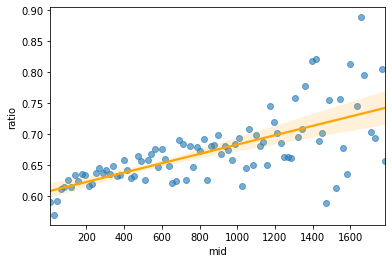

In [544]:
fig = plt.figure()
sns.regplot(data=prob_count2, x='mid', y='ratio',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6})

ax.set_title(f'# of Items - Answer Rate | bins={bins}')
ax.set_xlabel('# of Items')
ax.set_ylabel('Answer Rate')
plt.show();

* 문제를 많이 풀 수록 정답률이 올라가는 추세를 확인할 수 있다.